In [1]:
import cv2
import json
import numpy as np
from sympy.geometry import Point,Circle,Segment,intersection,Line
import matplotlib.pyplot as plt
from matplotlib.patches import Arc as Arc_patch
from matplotlib import collections  as mc
from IPython.display import clear_output

In [2]:
class Arc:
    def __init__(self,r,theta1,theta2,origin = (0,0)):
        x,y = origin
        self.x = x
        self.y = y
        self.r = r
        self.origin = origin
        self.theta1 = theta1
        self.theta2 = theta2
        self.circle = Circle(Point(x,y),r)        
        self.endpoints = [Point(self.x+r*np.cos(theta1),self.y+r*np.sin(theta1)),Point(self.x+r*np.cos(theta2),self.y+r*np.sin(theta2))]
    
    def __contains__(self,point):
        xp,yp = float(point.x)-self.x,float(point.y)-self.y
        rot = np.array([[np.cos(self.theta1),-1*np.sin(self.theta1)],
                        [np.sin(self.theta1),np.cos(self.theta1)]])
        xp,yp = np.array([xp,yp]) @ rot
        theta = np.arctan2(yp,xp) if (yp>=0 or (self.theta1<=0 and self.theta2>=0) or (self.theta2<=0 and self.theta1>=0)) else 2*np.pi + np.arctan2(yp,xp)
        return (theta>=0 and theta<=self.theta2-self.theta1) or (theta>=self.theta2-self.theta1 and theta<=0)

    def draw(self,ax,color):
        ax.add_patch(Arc_patch((self.x, self.y), 2*self.r,2*self.r, theta1=np.rad2deg(self.theta1), theta2=np.rad2deg(self.theta2), linewidth=1, color=color))       

#intersections
def arc_arc(gamma2,gamma2prime):
    eta,etaprime = gamma2.circle,gamma2prime.circle
    intersect = intersection(eta,etaprime)
    pts = []
    if len(intersect) > 0:
        if intersect[0] in gamma2 and intersect[0] in gamma2prime:
            pts.append(intersect[0])
    if len(intersect) > 1:
        if intersect[1] in gamma2 and intersect[1] in gamma2prime:
            pts.append(intersect[1])    
        
    return pts

def line_line(l1,l2):
    return intersection(l1,l2)

def line_arc(l1prime,gamma2):
    intersect = intersection(l1prime,gamma2.circle)
    pts = []
    if len(intersect)>0:
        if intersect[0] in gamma2:
            pts.append(intersect[0])
    if len(intersect)>1:
        if intersect[1] in gamma2:
            pts.append(intersect[1]) 
    return pts        
       
    

class Interval:
    """
    Defined by r1,r2,theta1,theta2 and the origin.
    r1<r2 and theta1<theta2
    """
    def __init__(self,r1,r2,theta1,theta2,origin=(0,0)):

        not_zero = lambda x: x if x != 0.0 else 1e-6    
        r1,r2,theta1,theta2 =  list(map(not_zero,[r1,r2,theta1,theta2])) 
        delta = abs(theta2-theta1)
        theta2 = max(theta1,theta2)
        theta2 = theta2%(2*np.pi)
        theta1 = theta2 - delta   
         
        
        self.r1 = r1
        self.r2 = r2  
        self.theta1 = theta1
        self.theta2 = theta2
        #print("self.theta2 = ",self.theta2)
        x,y = origin
        self.origin = origin
        self.x = x
        self.y = y
        self.gamma1 = Arc(r1,theta1,theta2,origin=origin)
        self.gamma2 = Arc(r2,theta1,theta2,origin=origin)
        self.l1 = Segment((x+r1*np.cos(theta1),y+r1*np.sin(theta1)),(x+r2*np.cos(theta1),y+r2*np.sin(theta1)))
        self.l2 = Segment((x+r1*np.cos(theta2),y+r1*np.sin(theta2)),(x+r2*np.cos(theta2),y+r2*np.sin(theta2)))
        self.l = [self.l1,self.l2]
        self.gamma = [self.gamma1,self.gamma2]    

    def __contains__(self,point):
        r = np.linalg.norm(np.array([float(point.x),float(point.y)])-np.array(self.origin))
        return (r<=self.r2 and r>=self.r1) and (point in self.gamma1)    
    
    def __repr__(self):
        return f"Interval({self.r1},{self.r2},{self.theta1},{self.theta2},{self.origin})"
    
    def draw(self,ax,color):
        try:
            l11, l12 = tuple(self.l1.points[0]),tuple(self.l1.points[1])
            l21, l22 = tuple(self.l2.points[0]),tuple(self.l2.points[1])
            lc = mc.LineCollection([[l11,l12],[l21,l22]], colors = color, linewidths=1)
            self.gamma1.draw(ax,color)
            self.gamma2.draw(ax,color)
            ax.add_collection(lc) 
            
        except AttributeError:
            self.gamma1.draw(ax,color)
            self.gamma2.draw(ax,color)
    
    def fast_analysis(self,Iprime):
        I = self
        test_pts = []
        O = Point(I.origin)
        D = np.linalg.norm(np.array(I.origin)-np.array(Iprime.origin))
        if D>I.r2 + Iprime.r2:
            return Interval(0,0,0,0,I.origin)



        for gmp in Iprime.gamma:
            for gmi in I.gamma:
                pts = arc_arc(gmi,gmp)
                test_pts += pts    
            for li in I.l:
                pts = line_arc(li,gmp)
                test_pts += pts 
            if D<=I.r2 + Iprime.r2:
                normal_line = Line(I.origin,Iprime.origin)
                normal_points = gmp.circle.intersection(normal_line)
                for foot_normal in normal_points:
                    if foot_normal in gmp:
                        if foot_normal in I:
                            test_pts += [foot_normal]
            if D**2<=I.r2**2 + Iprime.r2**2:
                try:
                    for line in gmp.circle.tangent_lines(O):
                        if len(line.points)>1:
                            tangent_pt = line.points[1]
                            if tangent_pt in gmp:
                                if tangent_pt in I:
                                    test_pts += [tangent_pt]
                except IndexError:
                    pass
        for lp in Iprime.l:
            for gmi in I.gamma:
                pts = line_arc(lp,gmi)
                test_pts += pts    
            for li in I.l:
                test_pts += line_line(li,lp) 
            base_perpendicular = lp.perpendicular_segment(O).points[1]
            if lp.contains(base_perpendicular):
                if base_perpendicular in I:
                    test_pts += [base_perpendicular]    


        for point in Iprime.gamma2.endpoints+Iprime.gamma1.endpoints:
            if point in I:
                test_pts+= [point]
        if not test_pts:
            return Interval(0,0,0,0,I.origin)
        def cart2pol(pt):
            x,y = float(pt.x),float(pt.y)
            xi,yi = np.array([x,y])-np.array(I.origin)
            rho = np.linalg.norm(np.array([xi,yi]))
            phi = np.arctan2(yi,xi) if (yi>=0 or (I.theta1*I.theta2<=0)) else 2*np.pi + np.arctan2(yi,xi)
            return [rho, phi]
        rad_pts = np.array(list(map(cart2pol,test_pts)))
        R = rad_pts[:,0]
        THETA = rad_pts[:,1]
        rmax,rmin = max(R),min(R)
        thetamax,thetamin = max(THETA),min(THETA)
        return Interval(rmin,rmax,thetamin,thetamax,I.origin)

 
    def complement(self,J):
        if J.r2 == 1e-6 and J.theta1 - J.theta2 == 0:
            return [self]
        Is = []
        Jtheta2,Jtheta1 = J.theta2,J.theta1
        if self.theta1*self.theta2<0:
            if J.theta1>self.theta2:
                Jtheta2,Jtheta1 = J.theta2-2*np.pi,J.theta1-2*np.pi
        #now I.theta1<J.theta1<J.theta2<I.theta2        
                
        if abs(self.theta1 - Jtheta1)>1e-4 and abs(self.theta1 - Jtheta1)<np.pi-1e-4:
            I1 = Interval(self.r1,self.r2,self.theta1,Jtheta1,self.origin)
            Is.append(I1)

            
        if abs(Jtheta1 - Jtheta2)>1e-4:    
            I2 = Interval(self.r1,J.r1,Jtheta1,Jtheta2,self.origin)
            Is.append(I2)

        if abs(Jtheta2 - self.theta2)>1e-4 and abs(Jtheta2 - self.theta2)<np.pi-1e-4:    
            I3 = Interval(self.r1,self.r2,Jtheta2,self.theta2,self.origin)
            Is.append(I3)

        return Is

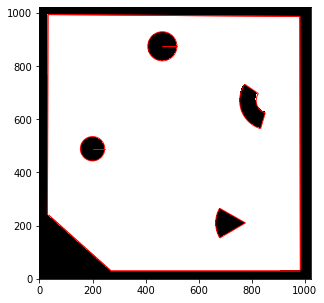

In [5]:
with open('obstacles.json') as f:   
    data = json.load(f)
obstacles = []
for obstacle in data['obstacles']:
    params,center = obstacle['params'],obstacle['center']
    obstacles.append(Interval(*params,center))
arena = cv2.imread("arena1.png")
arena = (1-cv2.cvtColor(arena,cv2.COLOR_RGB2GRAY)/255).astype('int')
fig,ax = plt.subplots(figsize=(5,5))
ax.imshow(arena,cmap = plt.cm.gray_r,origin="lower")
for obstacle in obstacles:
    obstacle.draw(ax,'red')
plt.show()

In [6]:
class Robot:
    radius = 25
    Δt = 1
    obstacles = [] # array with Interval objects

    
    def __init__(self,x_bot,y_bot,yaw,vi,vj,wi,wj):
        self.x_bot = x_bot
        self.y_bot = y_bot
        self.yaw = yaw
        self.vi = vi
        self.vj = vj
        self.wi = wi
        self.wj = wj
        self.color = 'blue'        
        self.trajectory = [[x_bot,y_bot,yaw]]
        self.fellows = []
        
    

        
    @property
    def interval(self):
        theta1 = self.yaw%(2*np.pi) - (self.wi - self.wj)*self.Δt
        theta2 = self.yaw%(2*np.pi) + (self.wi - self.wj)*self.Δt
        origin = (self.x_bot+self.radius*(np.cos(theta1)+np.cos(theta2))/(1e-6 + np.sin(theta1-theta2)),
                       self.y_bot+self.radius*(np.sin(theta1)+np.sin(theta2))/(1e-6 + np.sin(theta1-theta2)))

        n = self.radius/(1e-6+np.sin((theta2-theta1)/2))
        nu1 = n - self.radius
        nu2 = n + self.radius + (self.vi-self.vj)*self.Δt
        return Interval(nu1,nu2,theta1,theta2,origin)
        
    
    
    def __repr__(self):
        return f"Robot at {self.x_bot},{self.y_bot},{self.yaw}"
    
    
    def collision_detection(self):
        Js = []       
        I = self.interval
        for obstacle in self.obstacles:
            J = I.fast_analysis(obstacle)
            if not(J.r2 == 1e-6 and J.theta1 -J.theta2 == 0) :
                Js.append(J)
            del J 
        for fellow in self.fellows:
            J = I.fast_analysis(fellow.interval)
            if not(J.r2 == 1e-6 and J.theta1 -J.theta2 == 0) :
                Js.append(J)
            del J     
        return Js

    
    def generate_vw(self):
        min_angle = np.pi/24
        num_samples = np.ceil((abs(self.interval.theta2-self.interval.theta1)/min_angle)/2).astype('int')
        vws = []
        v = (self.interval.r2-self.interval.r1-2*self.radius)/self.Δt
        
        for i in range(1,num_samples,1):
            w = i*min_angle*self.Δt   
            vws.append([v,-1*w])
        for i in range(1,num_samples,1):
            w = i*min_angle*self.Δt
            vws.append([v,w])    
        return vws
            
    def collision_avoidance(self,Js,ax):
        """
        gives good v,w based on the inclusion region
        
        """
        I = self.interval
        vws = self.generate_vw()

        min_angle = np.pi/24
        comps = set()
        wt = lambda vw: vw[0]+(self.vi-self.vj)*abs(vw[1]/(self.wi-self.wj))
        
        if not len(Js) == 0:
            
            
            for J in Js:
                if not (J.r2 < 1e-4 and abs(J.theta2-J.theta1) < 1e-6):
                    comps.update(I.complement(J))
     
            for comp in comps:
                #print(comp)
                #comp.draw(ax,'magenta')
                if not(comp.theta2-I.theta2 or comp.theta1-I.theta1):
                    continue  
                else:   
                    for i,[v,w] in enumerate(vws):
    
                        if self.yaw%(2*np.pi)+w*self.Δt<= max(comp.theta1,comp.theta2)+np.arcsin(self.radius/(comp.r2-self.radius)) and \
                        self.yaw%(2*np.pi)+w*self.Δt>=min(comp.theta1,comp.theta2)-np.arcsin(self.radius/(comp.r2-self.radius)):
                            #np.pi/24 is min angle
                            vnew = ((comp.r2-comp.r1-2*self.radius)/self.Δt)
                            vnew = vnew if vnew>0 else 0
                            if vnew<vws[i][0] and vnew>=0: #bugfix
                                vws[i][0] = vnew

                               

            vwes = np.array(vws)
            np.random.shuffle(vwes)
            is_collide = True
            if max(vwes[:,0])<abs(self.vi-self.vj)*0.9:
                v_max = 0  #vwes[np.argmin(vwes[:,0])]*0.0
                ws = abs(self.wi-self.wj)
                print("escape")
                
             #vwes[np.argmax(wt(vwes-vwes[np.argmin(vwes[:,0])]).T)]  
            else:
                max_vw = np.array([vw for vw in vwes if vw[0] == self.vi-self.vj])
                if not len(max_vw):
                    v_max,ws = max_vw[np.argmax(max_vw[:,1])]
                    print("ok")
                else: 
                    v_max = 0  
                    ws = abs(self.wi-self.wj)
                
               
                    
            vwn = np.array([v_max,ws])

        else:
            
            vwn = np.array([(self.vi-self.vj),0])
            is_collide = False
        
        return vwn,is_collide

    
    def next_bot(self,Js,ax):
        if not len(Js):
            return self.next_pose(Js,ax)
        
        
#         Js = self.collision_detection()
        vw,is_collide = self.collision_avoidance(Js,ax)
        v,w = vw
        yaw = self.yaw + w*self.Δt
        x_bot = self.x_bot + v*np.cos(yaw)*self.Δt
        y_bot = self.y_bot + v*np.sin(yaw)*self.Δt
        self.yaw = yaw
        self.x_bot = x_bot
        self.y_bot = y_bot
        self.trajectory.append([x_bot,y_bot,yaw])
        
        return self
    def next_pose(self,Js,ax):
        
        
#         vw,is_collide = self.collision_avoidance(Js,traj_v,traj_w,ax)
#         v,w = vw
        v,w = (self.vi-self.vj),0
        yaw = self.yaw + w*self.Δt
        x_bot = self.x_bot + v*np.cos(yaw)*self.Δt
        y_bot = self.y_bot + v*np.sin(yaw)*self.Δt
        self.yaw = yaw
        self.x_bot = x_bot
        self.y_bot = y_bot
        self.trajectory.append([x_bot,y_bot,yaw])        
        
        
        return self
    def next_bots(self,ax):
        bots = []
        Js = self.collision_detection()
        vws,_ = self.collision_avoidance(Js,ax)
        for v,w in vws:
            
            yaw = self.yaw + w*self.Δt
            x_bot = self.x_bot + v*np.cos(yaw)*self.Δt
            y_bot = self.y_bot + v*np.sin(yaw)*self.Δt
            bots.append(Robot(x_bot,y_bot,yaw,self.vi,self.vj,self.wi,self.wj))

        return bots
     
    def plot(self,ax):
        bot_circle = plt.Circle( (self.x_bot, self.y_bot),self.radius,color=self.color)
        #arrow = ax.arrow(self.x_bot,self.y_bot,self.radius*np.cos(self.yaw),self.radius*np.sin(self.yaw))
        patch = ax.add_patch(bot_circle)

        #return [bot_circle,arrow]
                           
    def plot_interval(self,ax):
        self.interval.draw(ax,self.color)

    
    @classmethod
    def set_environment(cls,obstacles):
        cls.obstacles = obstacles
        
       

run :  1
run :  2
run :  3
run :  4
run :  5


C:\Users\Kshitij\anaconda3\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in arcsin


run :  6
run :  7
run :  8
escape
run :  9
run :  10
run :  11
run :  12
run :  13
run :  14
run :  15
run :  16
run :  17
run :  18
run :  19


C:\Users\Kshitij\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


run :  20
run :  21
run :  22
run :  23
run :  24
run :  25
run :  26
run :  27
run :  28
escape
run :  29
run :  30
run :  31
run :  32
run :  33
run :  34
run :  35
run :  36
run :  37
run :  38
run :  39
run :  40
run :  41
run :  42
run :  43
run :  44
run :  45
run :  46
run :  47
run :  48
run :  49
run :  50
run :  51
run :  52
run :  53
run :  54
run :  55
run :  56
run :  57
run :  58
run :  59
run :  60
run :  61
run :  62
run :  63
run :  64
run :  65
run :  66
run :  67
run :  68
run :  69
run :  70
run :  71
escape
run :  72
escape
run :  73
run :  74
run :  75
run :  76
run :  77
escape
run :  78
run :  79
run :  80
run :  81
run :  82
escape
run :  83
run :  84
run :  85
run :  86
run :  87
run :  88
run :  89
run :  90
run :  91
run :  92
run :  93
run :  94
run :  95
run :  96
run :  97
run :  98
run :  99
run :  100


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

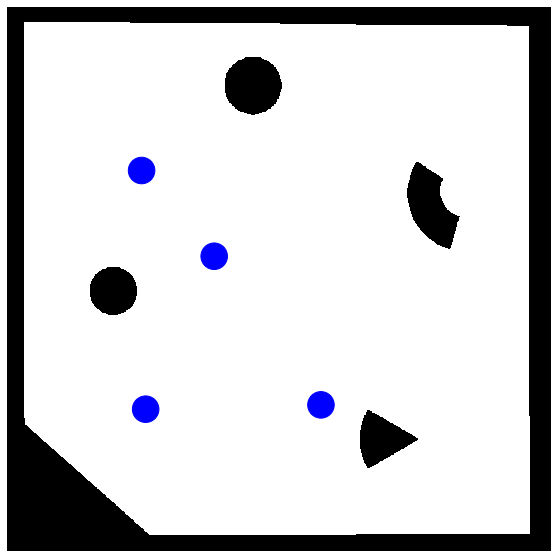

In [7]:

robot1 = Robot(800,900,-np.pi/2,35,0,1.13,0)
#robot = Robot(800,770,4.5,80,0,1,0)
#robot = Robot(400,400,0,100,0,1,0)
robot1.set_environment(obstacles)
robot2 = Robot(100,900, 0,35,0,1.13,0)
robot3 = Robot(300,300, 0.5,35,0,1.13,0)
robot4 = Robot(900,200, np.pi/2,35,0,1.13,0)

robot1.fellows = [robot2,robot3,robot4]
robot2.fellows = [robot1,robot3,robot4]
robot3.fellows = [robot1,robot2,robot4]
robot4.fellows = [robot1,robot2,robot3]

# fig,ax = plt.subplots(figsize=(8,8))
# ax. set_aspect('equal')
# ax.set_xlim([0, 1024])
# ax.set_ylim([0, 1024])
# ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
# robot.plot(ax)
# robot.plot_interval(ax)
for i in range(100):
    try:
        #clear_output(wait = True)
        plt.clf()
        fig,ax = plt.subplots(figsize=(10,10))
        ax. set_aspect('equal')
        ax.set_xlim([0, 1024])
        ax.set_ylim([0, 1024])
        ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
        #ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
        
        robot1.plot(ax)
        robot2.plot(ax)
        robot3.plot(ax)        
        robot4.plot(ax)

        
        
        
 
        Js1 = robot1.collision_detection() 
        Js2 = robot2.collision_detection() 
        Js3 = robot3.collision_detection()        
        Js4 = robot4.collision_detection() 
 
        
        robot1 = robot1.next_bot(Js1,ax) 
        robot2 = robot2.next_bot(Js2,ax) 
        robot3 = robot3.next_bot(Js3,ax)        
        robot4 = robot4.next_bot(Js4,ax) 
 
        
        
#         robot1 = robot1.next_pose(Js1,1,ax) 
#         robot2 = robot2.next_pose(Js2,0,ax) 
#         robot3 = robot3.next_pose(Js3,0,ax)

        #plt.show()
        plt.axis("off")
        plt.savefig(f'captures4/fig{i}.png',bbox_inches='tight',dpi=133)
        print("run : ",i+1)   
    except KeyboardInterrupt:
        try:
            break
        except GeometryError:
            break
trajectories = {}
trajectories["robot1"] = robot1.trajectory
trajectories["robot2"] = robot2.trajectory
trajectories["robot3"] = robot3.trajectory
trajectories["robot4"] = robot4.trajectory

with open('trajectories4r.json', 'w') as outfile:
    json.dump(trajectories,outfile,indent=4)

run :  1
run :  2
run :  3
escape
run :  4


C:\Users\Kshitij\anaconda3\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in arcsin


run :  5
run :  6
run :  7
run :  8
run :  9
run :  10
run :  11
escape
run :  12
run :  13
run :  14
run :  15
run :  16
run :  17
run :  18
run :  19


C:\Users\Kshitij\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


escape
run :  20
run :  21
run :  22
run :  23
run :  24
run :  25
run :  26
run :  27
run :  28
run :  29
run :  30
run :  31
run :  32
run :  33
run :  34
run :  35
run :  36
run :  37
run :  38
run :  39
run :  40
run :  41
run :  42
run :  43
run :  44
run :  45
run :  46
run :  47
run :  48
run :  49
run :  50
run :  51
escape
run :  52
run :  53
run :  54
run :  55
run :  56
run :  57
run :  58
run :  59
run :  60
run :  61
escape
run :  62
escape
escape
run :  63
run :  64
run :  65
run :  66
run :  67
run :  68
run :  69
run :  70
run :  71
run :  72
run :  73
run :  74
run :  75
run :  76
run :  77
run :  78
escape
run :  79
run :  80
run :  81
run :  82
run :  83
run :  84
run :  85
run :  86
escape
run :  87
run :  88
run :  89
run :  90
run :  91
run :  92
run :  93
run :  94
run :  95
run :  96
run :  97
run :  98
escape
run :  99
run :  100


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

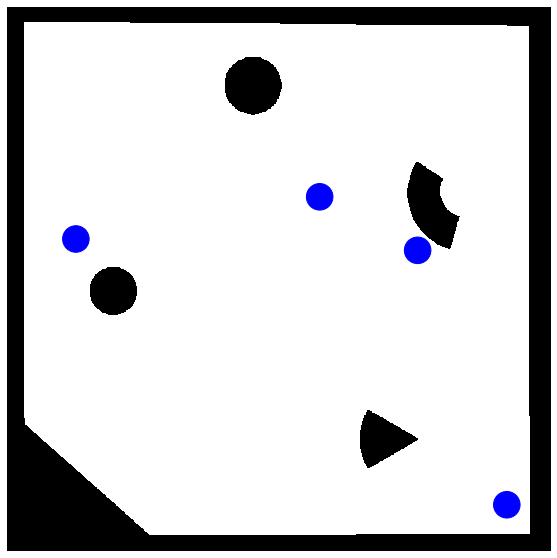

In [9]:
for i in range(100):
    try:
        #clear_output(wait = True)
        plt.clf()
        fig,ax = plt.subplots(figsize=(10,10))
        ax. set_aspect('equal')
        ax.set_xlim([0, 1024])
        ax.set_ylim([0, 1024])
        ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
        #ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
        
        robot1.plot(ax)
        robot2.plot(ax)
        robot3.plot(ax)
        robot4.plot(ax)

        
        
        
 
        Js1 = robot1.collision_detection() 
        Js2 = robot2.collision_detection() 
        Js3 = robot3.collision_detection()
        Js4 = robot4.collision_detection() 
 
        
        robot1 = robot1.next_bot(Js1,ax) 
        robot2 = robot2.next_bot(Js2,ax) 
        robot3 = robot3.next_bot(Js3,ax)
        robot4 = robot4.next_bot(Js4,ax) 
 
        
        
#         robot1 = robot1.next_pose(Js1,1,ax) 
#         robot2 = robot2.next_pose(Js2,0,ax) 
#         robot3 = robot3.next_pose(Js3,0,ax)

        #plt.show()
        plt.axis("off")
        plt.savefig(f'captures4/fig{100+i}.png',bbox_inches='tight',dpi=133)
        print("run : ",i+1)   
    except KeyboardInterrupt:
        try:
            break
        except GeometryError:
            break
trajectories = {}
trajectories["robot1"] = robot1.trajectory
trajectories["robot2"] = robot2.trajectory
trajectories["robot3"] = robot3.trajectory
trajectories["robot4"] = robot4.trajectory

with open('trajectories4rx.json', 'w') as outfile:
    json.dump(trajectories,outfile,indent=4)

In [18]:
heat_map = np.zeros((50,50))
with open('trajectories1.json') as f:   
    data = json.load(f)

tot = data['robot1']+data['robot2']+data['robot3']

dots = np.array(tot)[:,0:2]
for dot in dots:

    j = int(dot[0]/20.6)
    i = int(dot[1]/20.6)
    
    heat_map[i,j]+=0.01



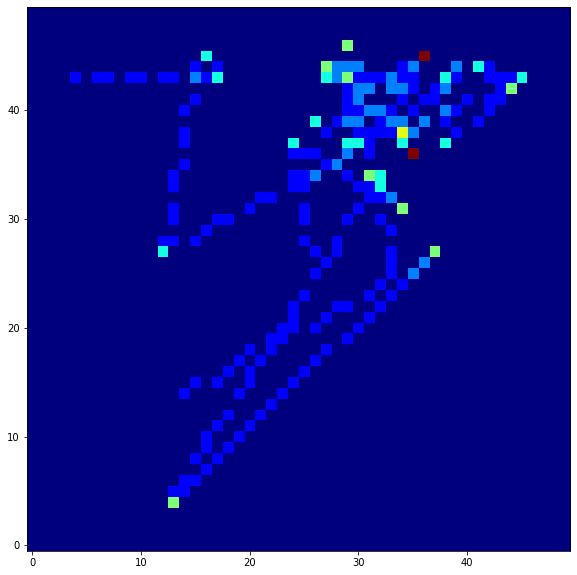

In [20]:
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(heat_map,cmap = "jet",origin="lower")
plt.savefig("grid100run.png",bbox_inches='tight')

image : 0
image : 1
image : 2
image : 3
image : 4
image : 5
image : 6
image : 7
image : 8
image : 9
image : 10
image : 11
image : 12
image : 13
image : 14
image : 15
image : 16
image : 17
image : 18
image : 19
image : 20
image : 21
image : 22
image : 23
image : 24
image : 25
image : 26
image : 27
image : 28
image : 29
image : 30
image : 31
image : 32
image : 33
image : 34
image : 35
image : 36
image : 37
image : 38
image : 39
image : 40
image : 41
image : 42
image : 43
image : 44
image : 45
image : 46
image : 47
image : 48
image : 49
image : 50
image : 51
image : 52
image : 53
image : 54
image : 55
image : 56
image : 57
image : 58
image : 59
image : 60
image : 61
image : 62
image : 63
image : 64
image : 65
image : 66
image : 67
image : 68
image : 69
image : 70
image : 71
image : 72
image : 73
image : 74
image : 75
image : 76
image : 77
image : 78
image : 79
image : 80
image : 81
image : 82
image : 83
image : 84
image : 85
image : 86
image : 87
image : 88
image : 89
image : 90
image : 9

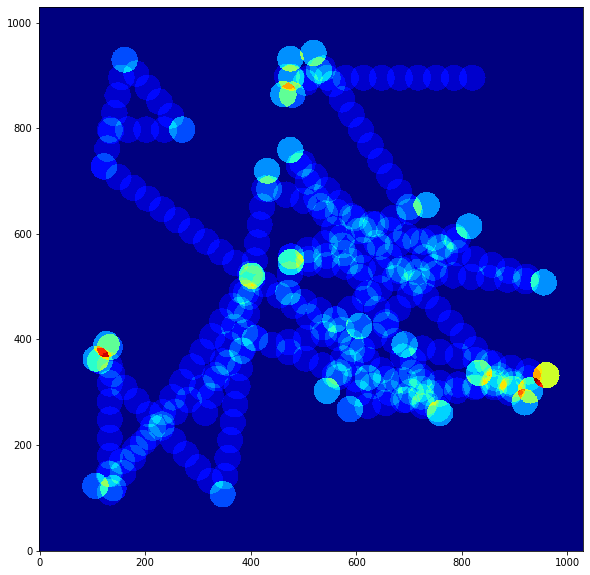

In [8]:
hm_highres = np.zeros((1030,1030))

for num in range(100):
    img = cv2.imread(f"captures4/fig{num}.png")
    for i in range(1030):
        for j in range(1030):
            r,g,b = img[i,j] 
    
            if r==255 and g==0 and b==0:
                hm_highres[j,i]+=0.01
                
    print("image :",num)
    
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(hm_highres,cmap='jet',origin='lower')    


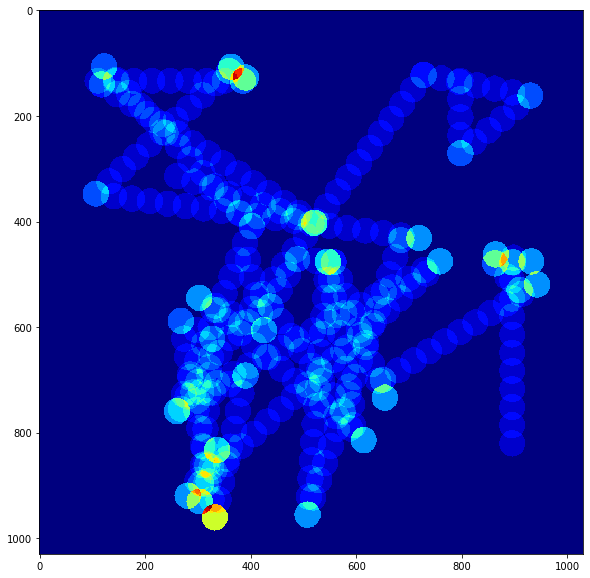

In [10]:
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(hm_highres.T,cmap='jet')  
#plt.axis("off")
plt.savefig("first2c.png",bbox_inches='tight')

In [116]:
img = cv2.imread(f"captures1/fig{0}.png")
#img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

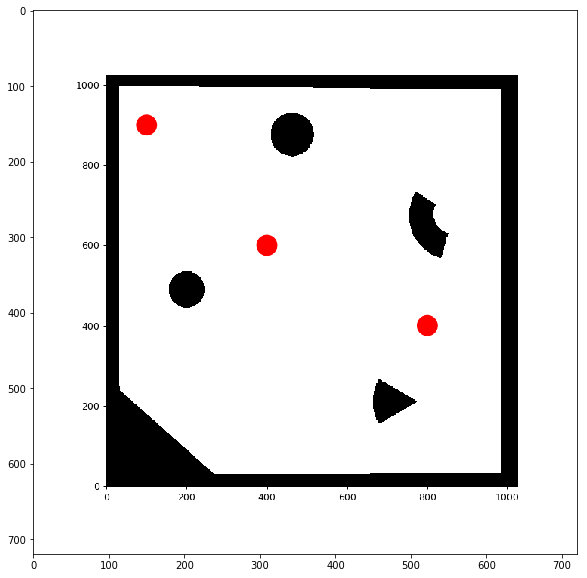

In [125]:
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(img)

In [5]:
import imageio
images = []
for i in range(100):
    filename = f'captures3/fig{i}.png'
    #filename1 = f'captures2/fig{i}a.png'
    #print(filename)
    images.append(imageio.imread(filename))
    images.append(imageio.imread(filename))
imageio.mimsave('heat_map_test.gif', images)